In [13]:
%matplotlib inline

# Notebook for training predictive models
### Import packages

In [15]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import load_model as keras_load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from sklearn.pipeline import Pipeline
from keras.models import Sequential

from keras.models import load_model
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import glob
import os

from visualize_game import visualize_training_results
from settings import *

### Global variables

In [2]:
# Define numerical, categorical, and y columns
# numerical_cols = ['x', 'y', 'v_x', 'v_y', 'a_x', 'a_y', 'distance_ran', 'minute', 'frame']
# categorical_cols = ['role', 'team', 'team_direction']
# y_cols = ['x_future', 'y_future']
numerical_cols = ['x', 'y', 'v_x', 'v_y', 'a_x', 'a_y']
categorical_cols = ['team_direction', 'role']
y_cols = ['x_future', 'y_future']

# Define the length of the sequences
sequence_length = FPS * seconds_into_the_future

### Helper functions

In [3]:
# Split the games into train, test, and validtion. This way, each game will be treated seperatly
def split_match_ids(match_ids, train_size=0.7, test_size=0.1, val_size=0.2, random_state=42):
    # Calculate the remaining size after the test and validation sizes are removed
    remaining_size = 1.0 - train_size

    # Check if the sum of sizes is not equal to 1
    if remaining_size < 0 or abs(train_size + test_size + val_size - 1.0) > 1e-6:
        raise ValueError("The sum of train_size, test_size, and val_size must be equal to 1.")
    
    # Split the match IDs into train, test, and validation sets
    train_ids, remaining_ids = train_test_split(match_ids, train_size=train_size, random_state=random_state)
    val_ids, test_ids = train_test_split(remaining_ids, test_size=test_size / remaining_size, random_state=random_state)
    
    return train_ids, test_ids, val_ids
    
# Get the next model file name based on the number of current models
def get_next_model_filename(model_name):
    models_folder = "./models/"

    # Get a list of existing model filenames in the models folder
    existing_models = [filename for filename in os.listdir(models_folder) if filename.endswith('.h5') and model_name in filename]

    # Determine the number of existing models
    num_existing_models = len(existing_models)

    # Construct the filename for the next model
    next_model_filename = f"{model_name}_{num_existing_models + 1}.h5"

    return os.path.join(models_folder, next_model_filename)

In [4]:
# Prepare data before training
def prepare_data(frames_dfs):

    # Initialize lists to store features and labels
    X_data = []
    y_data = []

    # For each game
    for frames_df in frames_dfs:
        # Fill NaN values with zeros for numerical columns
        frames_df[numerical_cols] = frames_df[numerical_cols].fillna(0)

        # Drop rows with NaN values in the labels (y)
        frames_df.dropna(subset=y_cols, inplace=True)

        # Extract features and labels from group
        X = frames_df[numerical_cols + categorical_cols]
        y = frames_df[y_cols]

        # Append the data
        X_data.append(X)
        y_data.append(y)

    # Concatenate the lists to create the final feature and label DataFrame
    X_data_df = pd.concat(X_data)
    y_data_df = pd.concat(y_data)

    # Apply label encoding to categorical variables
    for col in categorical_cols:
        label_encoder = LabelEncoder()
        X_data_df[col] = label_encoder.fit_transform(X_data_df[col])

    # Define column transformer for standard scaling numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols)
        ],
        remainder='passthrough'
    )

    # Create pipeline for preprocessing and apply it to X_data
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    X_data_scaled = pipeline.fit_transform(X_data_df)

    # Retrieve the transformed feature names from ColumnTransformer
    transformed_column_names = numerical_cols + categorical_cols

    # Create a DataFrame from the preprocessed feature data
    X_data_scaled_df = pd.DataFrame(X_data_scaled, columns=transformed_column_names)

    # Convert categorical columns to int
    X_data_scaled_df[categorical_cols] = X_data_scaled_df[categorical_cols].astype('int8')

    return X_data_scaled_df, y_data_df

# TODO: Test this function. It's straight from the goat
def prepare_sequential_data(X_data, y_data, sequence_length):
    # Convert pandas DataFrames to NumPy arrays
    X_data_np = X_data.to_numpy()
    y_data_np = y_data.to_numpy()

    data_length = len(X_data)

    # Create an array of indices to extract sequences
    indices = np.arange(data_length - sequence_length + 1)[:, None] + np.arange(sequence_length)

    # Use advanced indexing to extract sequences directly
    X_seq = X_data_np[indices]
    y_seq = y_data_np[sequence_length - 1:]

    return X_seq, y_seq

In [5]:
# Add a column for distance wrongly predicted (in metres) for each object
def add_pred_error(frames_df):
    # Create a vector with the Eculidian distance between the true position and the predicted position
    frames_df['pred_error'] = round(((frames_df['x_future_pred'] - frames_df['x_future'])**2 + (frames_df['y_future_pred'] - frames_df['y_future'])**2)**0.5, 2)
    
# Add a column for distance wrongly predicted (in metres) for each object. Also return average_pred_error
def total_error_loss(frames_df, include_ball=False, ball_has_to_be_in_motion=True):
    # Add 'pred_error' column if empty
    if 'pred_error' not in frames_df:
        add_pred_error(frames_df)
    
    # Create a new column to store modified pred_error values
    frames_df['pred_error_tmp'] = frames_df['pred_error']
    
    # If specified, set pred_error to None for frames where the ball is not in motion
    if ball_has_to_be_in_motion:
        frames_df.loc[frames_df["ball_in_motion"] != True, 'pred_error_tmp'] = None

    # If specified, set pred_error to None for rows where 'team' is 'ball'
    if not include_ball:
        frames_df.loc[frames_df['team'] == 'ball', 'pred_error_tmp'] = None

    # Calculate average pred_error_tmp, excluding rows where pred_error is None
    average_pred_error = frames_df['pred_error_tmp'].mean()

    # Drop the temporary column
    frames_df.drop(columns=['pred_error_tmp'], inplace=True)

    return round(average_pred_error, 2)

# Use a model to make predictions on a set of games, and calculate the error
def predict_and_evaluate(model, X_data, frames_dfs, include_ball=False, ball_has_to_be_in_motion=True):
    # Make predictions using the loaded model
    predictions = model.predict(X_data)
    
    # Concatenate the frames DataFrames into a single large DataFrame
    frames_concatenated_df = pd.concat(frames_dfs, ignore_index=True)

    # Extract the predicted values
    x_future_pred = predictions[:, 0]
    y_future_pred = predictions[:, 1]

    # Add the predicted values to 'frames_concatenated_df'
    frames_concatenated_df['x_future_pred'] = x_future_pred
    frames_concatenated_df['y_future_pred'] = y_future_pred

    # Calculate error
    error = total_error_loss(frames_concatenated_df, include_ball, ball_has_to_be_in_motion)

    return error

### Load frames

In [6]:
# Load the processed/frames
def load_all_processed_frames():
    # Create DataFrame for storing all frames
    frames_dfs = []
    # Load frames_df
    for selected_season in seasons:
        for selected_competition in competitions:
            # Define paths
            DATA_FOLDER_PROCESSED = f"{DATA_LOCAL_FOLDER}/data/{selected_season}/{selected_competition}/processed"

            # Find all frames parquet files
            match_paths = glob.glob(os.path.join(DATA_FOLDER_PROCESSED, "*.parquet"))

            # Extract IDs without the ".parquet" extension
            match_ids = [os.path.splitext(os.path.basename(path))[0] for path in match_paths][0:10]
            # match_ids = ['49e6bfdf-abf3-499d-b60e-cf727c6523c1']

            # For all matches
            for match_id in match_ids:
                # Convert parquet file to a DataFrame
                file_path_match = f"{DATA_FOLDER_PROCESSED}/{match_id}.parquet"
                frames_df = pd.read_parquet(file_path_match)
                
                # Append the DataFrame to frames_dfs
                frames_dfs.append(frames_df)

    return frames_dfs

# Load every frames_df to a list
frames_dfs = load_all_processed_frames()

# Create an internal match_id for each game
match_ids = range(len(frames_dfs))

# Split match IDs into train, test, and validation sets
train_ids, test_ids, val_ids = split_match_ids(match_ids=match_ids)

# Select frames data for training, testing, and validation
train_frames_dfs = [frames_dfs[i] for i in train_ids]
test_frames_dfs = [frames_dfs[i] for i in test_ids]
val_frames_dfs = [frames_dfs[i] for i in val_ids]

In [7]:
# Prepare the data for training
def prepare_all_dfs():
    X_train, y_train = prepare_data(train_frames_dfs)
    X_val, y_val = prepare_data(val_frames_dfs)
    X_test, y_test = prepare_data(test_frames_dfs)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Store the prepared data to parquet files
def store_prepared_data(X_train, y_train, X_val, y_val, X_test, y_test):
    prepared_data_path = f"{DATA_LOCAL_FOLDER}/data/prepared_data"

    # Store DataFrames in Parquet format
    X_train.to_parquet(f"{prepared_data_path}/X_train.parquet")
    y_train.to_parquet(f"{prepared_data_path}/y_train.parquet")
    X_val.to_parquet(f"{prepared_data_path}/X_val.parquet")
    y_val.to_parquet(f"{prepared_data_path}/y_val.parquet")
    X_test.to_parquet(f"{prepared_data_path}/X_test.parquet")
    y_test.to_parquet(f"{prepared_data_path}/y_test.parquet")

# Read the stored parquet files
def read_prepared_data():
    prepared_data_path = f"{DATA_LOCAL_FOLDER}/data/prepared_data"

    X_train = pd.read_parquet(f"{prepared_data_path}/X_train.parquet")
    y_train = pd.read_parquet(f"{prepared_data_path}/y_train.parquet")
    X_val   = pd.read_parquet(f"{prepared_data_path}/X_val.parquet")
    y_val   = pd.read_parquet(f"{prepared_data_path}/y_val.parquet")
    X_test  = pd.read_parquet(f"{prepared_data_path}/X_test.parquet")
    y_test  = pd.read_parquet(f"{prepared_data_path}/y_test.parquet")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Prepare, store, and load data
# X_train, y_train, X_val, y_val, X_test, y_test = prepare_all_dfs()
# store_prepared_data(X_train, y_train, X_val, y_val, X_test, y_test)
# X_train, y_train, X_val, y_val, X_test, y_test = read_prepared_data()

## Predictive model 1
### Dense NN model

In [8]:
def define_NN_model(input_shape):
    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2)  # Output layer with 2 units for x_future and y_future
    ])

    return model

def train_NN_model(train_frames_dfs, val_frames_dfs):
    # Prepare the data
    X_train, y_train = prepare_data(train_frames_dfs)
    X_val, y_val = prepare_data(val_frames_dfs)

    # Only keep numerical columns
    X_train = X_train[numerical_cols]
    X_val = X_val[numerical_cols]

    # Define the model
    model = define_NN_model(X_train.shape[1])

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model and capture the output
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=32, verbose=2)

    # Save the trained model to disk
    model_filename = get_next_model_filename("NN_model")
    model.save(model_filename)

    # Generate the corresponding txt filename
    output_txt_filename = os.path.splitext(model_filename)[0] + ".txt"

    # Write the output directly to the txt file
    with open(output_txt_filename, 'w') as f:
        # Write the output from model.fit
        f.write(str(history.history) + '\n')

        # Make predictions and evaluate the validation error
        train_error = predict_and_evaluate(model, X_train, train_frames_dfs, include_ball=False, ball_has_to_be_in_motion=True)
        f.write(f"Training error: {train_error}\n")

        # Make predictions and evaluate the validation error
        val_error = predict_and_evaluate(model, X_val, val_frames_dfs, include_ball=False, ball_has_to_be_in_motion=True)
        f.write(f"Validation error: {val_error}\n")

In [9]:
# Train the NN model
train_NN_model(train_frames_dfs, val_frames_dfs)

2024-03-12 11:50:46.182762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31132 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0
2024-03-12 11:50:50.657383: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5b504b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 11:50:50.657415: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-03-12 11:50:50.661882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-12 11:50:50.777132: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


724882/724882 - 1087s - loss: 11.3060 - val_loss: 15.8219 - 1087s/epoch - 1ms/step
202645/202645 [==============================] - 144s 711us/step


## Predictive model 2
### Embedding layers

In [10]:
def adjust_for_embeddings(X_data_df):
    # Split the DataFrame into numerical and categorical components
    X_numerical = X_data_df.drop(columns=categorical_cols)
    X_categorical = {col: X_data_df[col].values for col in categorical_cols}
    
    return X_numerical, X_categorical

def define_NN_model_with_embedding(numerical_input_shape, n_team_directions=3, n_roles=13):
    # Inputs
    team_direction_input = Input(shape=(1,), name='team_direction_input')
    role_input = Input(shape=(1,), name='role_input')
    numerical_input = Input(shape=(numerical_input_shape,), name='numerical_input')
    
    # Embeddings
    team_direction_embedding = Embedding(input_dim=n_team_directions, output_dim=2, name='team_direction_embedding')(team_direction_input)
    role_embedding = Embedding(input_dim=n_roles, output_dim=5, name='role_embedding')(role_input)
    
    # Flatten the embedding outputs
    team_direction_flat = Flatten()(team_direction_embedding)
    role_flat = Flatten()(role_embedding)
    
    # Concatenate all features
    concatenated_features = Concatenate()([team_direction_flat, role_flat, numerical_input])
    
    # Dense layers
    dense_layer_1 = Dense(64, activation='relu')(concatenated_features)
    dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)
    output_layer = Dense(2)(dense_layer_2)  # Assuming 2 units for x_future and y_future
    
    # Model
    model = Model(inputs=[team_direction_input, role_input, numerical_input], outputs=output_layer)
    
    return model

def train_NN_model_with_embedding(train_frames_dfs, val_frames_dfs):
    # Prepare data
    X_train, y_train = prepare_data(train_frames_dfs)
    X_val, y_val = prepare_data(val_frames_dfs)

    # Adjust for embeddings for both training and validation sets
    X_train_numerical, X_train_categorical = adjust_for_embeddings(X_train)
    X_val_numerical, X_val_categorical = adjust_for_embeddings(X_val)

    # Construct input data suitable for the embedding layers
    X_train_input = [X_train_categorical['team_direction'].reshape(-1, 1), X_train_categorical['role'].reshape(-1, 1), X_train_numerical]
    X_val_input = [X_val_categorical['team_direction'].reshape(-1, 1), X_val_categorical['role'].reshape(-1, 1), X_val_numerical]

    # Define the model
    model = define_NN_model_with_embedding(numerical_input_shape=X_train_numerical.shape[1])

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model with the corrected input format
    history = model.fit(X_train_input, y_train, validation_data=(X_val_input, y_val), epochs=1, batch_size=32, verbose=2)

    # Save the trained model to disk
    model_filename = get_next_model_filename("NN_embedding_model")
    model.save(model_filename)

    # Generate the corresponding txt filename
    output_txt_filename = os.path.splitext(model_filename)[0] + ".txt"

    # Write the output directly to the txt file
    with open(output_txt_filename, 'w') as f:
        # Write the output from model.fit
        f.write(str(history.history) + '\n')

        # Make predictions and evaluate the training error
        train_error = predict_and_evaluate(model, X_train_input, train_frames_dfs, include_ball=False, ball_has_to_be_in_motion=True)
        f.write(f"Training error: {train_error}\n")

        # Make predictions and evaluate the validation error
        val_error = predict_and_evaluate(model, X_val_input, val_frames_dfs, include_ball=False, ball_has_to_be_in_motion=True)
        f.write(f"Validation error: {val_error}\n")


In [11]:
# Train the NN model with embedding layers
train_NN_model_with_embedding(train_frames_dfs, val_frames_dfs)

724882/724882 - 1433s - loss: 10.8935 - val_loss: 17.7615 - 1433s/epoch - 2ms/step
202645/202645 [==============================] - 172s 847us/step


## Predictive model 3
### LSTM model

In [12]:
def define_LSTM_model(input_shape):
    # Define the lengt of the sequence
    timesteps = 5 * FPS

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', input_shape=(timesteps, input_shape[1])),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2)  # Output layer with 2 units for x_future and y_future
    ])

    return model

def train_LSTM_model(X_train, y_train, X_val, y_val, val_frames_dfs):
    # Define the model
    model = define_LSTM_model(X_train.shape[1:])

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

    # Save the trained model to disk
    model.save(get_next_model_filename("LSTM_model"))

    # Print the error using total_error_loss function
    train_error = total_error_loss(train_frames_dfs, include_ball=False, ball_has_to_be_in_motion=True)
    val_error = total_error_loss(val_frames_dfs, include_ball=False, ball_has_to_be_in_motion=True)
    print("Training Error:", train_error)
    print("Validation Error:", val_error)

def train_LSTM(train_frames_dfs, val_frames_dfs):
    # Prepare the data for training
    X_train, y_train = prepare_data(train_frames_dfs)

    # Prepare the data for validation
    X_val, y_val = prepare_data(val_frames_dfs)

    # Train the model
    train_model(X_train, y_train, X_val, y_val, val_frames_dfs)

### Visualize training results

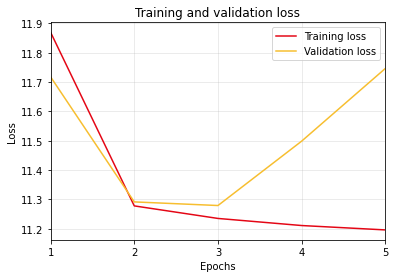

In [16]:
# Visualize training results
training_results = {
    'loss': [11.86983871459961, 11.278080940246582, 11.235326766967773, 11.211169242858887, 11.196228981018066],
    'val_loss': [11.717867851257324, 11.291694641113281, 11.279356956481934, 11.498793601989746, 11.746583938598633]
}

visualize_training_results(training_results)